##### Publication trends forecasting outputs

* Train+val+test Data covers ~1960-2019.
    * Model/features optimized over 1980-2010

* Prediction 5 years (inclusive) in advance

* Temporal split over data

* `y_raw` = Actual amount of publications (normalized out of total pubs that year in pubmed)
* `preds` = model predictions


* SparkBeyond Validation set ~ 2010-2013 , Test set 2014-2019
    * SB Train+val+test Data covers 1980-2019.
    * Raw/context data covers more (and I output that here)
* Prediction 5 years (inclusive) in advance


 * I try redoing time series CV/split here from scratch , to better show predicitons. 
     * https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html

In [1]:
import pandas as pd
import seaborn as sns
%matplotlib inline 

from sklearn.model_selection import cross_val_predict,TimeSeriesSplit
from sklearn.ensemble import HistGradientBoostingRegressor 
from sklearn import linear_model
from sklearn.linear_model import LinearRegression,Ridge
from sklearn.pipeline import Pipeline
import numpy as np
from catboost import CatBoostRegressor

pd.set_option('mode.use_inf_as_na', True)

In [2]:
FILTER_GROUP_SIZES = True

DIFF_TARGET = False#True # set target to diff vs 5 years ago. i.e tougher baseline

In [3]:
def plot_var_preds(df,val:str="subthalamus"):
#     df.loc[df["variable"].str.contains(val,case=False)][["y_raw","preds"]].plot(title=val)# "y_raw_predicted"
    df.loc[df["variable"].str.lower()==val.lower()][["y_raw","preds"]].plot(title=val)
    
import sklearn.metrics as metrics
def regression_results(y_true, y_pred):

    # Regression metrics
    explained_variance=metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error=metrics.mean_absolute_error(y_true, y_pred) 
    mse=metrics.mean_squared_error(y_true, y_pred) 
    
    median_absolute_error=metrics.median_absolute_error(y_true, y_pred)
    r2=metrics.r2_score(y_true, y_pred)

    print('r2: ', round(r2,3))
    print('MAE (Mean absolute error):', round(mean_absolute_error,4))
    print('Median absolute error):', round(median_absolute_error,4))
#     print('MSE: ', round(mse,4))
    print('RMSE: ', round(np.sqrt(mse),4))
    print('explained_variance: ', round(explained_variance,4))    
    try:
        mape = metrics.mean_absolute_percentage_error(y_true, y_pred)
        print('mape: ', round(mape,4))
    except:()
    try: 
        mean_squared_log_error=metrics.mean_squared_log_error(y_true, y_pred)
        print('mean_squared_log_error: ', round(mean_squared_log_error,4))
    except:()

        
        
def evaluate(model = CatBoostRegressor(cat_features= ["variable"],verbose=False,has_time=True),X = None):
    """https://stats.stackexchange.com/questions/495151/cross-validation-for-time-series-what-am-i-doing-wrong
    https://stackoverflow.com/questions/51597507/sklearn-timeseriessplit-error-keyerror-0-1-2-not-in-index
    """
    # train model on training dataset
    i = 0
    tscv = TimeSeriesSplit(10)
    # df_feat["preds"] = np.NaN
    for train_index, test_index in tscv.split(X): #df_feat):
        i +=1
        print(i)
#         if i%2==0: print(i)
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
#         X_train, X_test = X.index[train_index], X.index[test_index]#X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]
        model = CatBoostRegressor(iterations=600,
                                  cat_features= ["variable"],#[0], #["variable"],
                          verbose=False,has_time=True)
#         print("fit")
#         model.fit(X_train, y_train)
        model.fit(X_train, y_train,
#                   early_stopping_rounds=10,
#                   eval_set=(X_test, y_test),
                  #plot=(i%3==0),
#                  baseline=X_train["lag5"].values)#pd.concat([X_train["lag5"],X_test["lag5"]]).values)
                  )
#         print("doing pred")
        y_predict = model.predict(X_test)
#         print("assigning pred")
#         df_feat.loc[test_index,"preds"] =y_predict
        df_feat.iloc[test_index,-1] =y_predict  ##
    print("\n Done")


#### plot (lagged?) correlation of inputs and target in raw data

In [4]:
df_targets = pd.read_csv("trends_v6.csv.gz",parse_dates=["Year","first","start"],infer_datetime_format=True)

df_targets["target_5"] = df_targets.groupby("variable")["y_raw"].shift(-5) ## target in 5 years

# df_targets[["Year","variable","y_raw","target_5"]]
df_targets = df_targets.loc[(df_targets["Year"]>= df_targets["start"]) & (df_targets["year_num"]>= 1979) ]
df_targets.drop(columns=[
                         "pct_diff_lag6","y_pct_bins",
#                          "y_pct_diff","year_num",
                         "lag1","lag2","lag3","lag4",
                         "diff_lag6",
#                          "pct_diff_lag5",
                         "first","start","lag6"],errors="ignore",inplace=True)
print(df_targets.shape)


df_targets["lag5_pct_new"] = df_targets["diff_lag5"].div(df_targets["y_raw"])# pct diff vs 5 years ago
df_targets.head(8)

(4823, 20)


,Year,variable,y_raw,reviews,research_review_diff,research_review_ratio,pct_diff,patent_count,patent_frac,patent_yearly_total,...,review_research_ratio_2,review_research_diff_2,pat_div_research,year_num,y_diff,y_pct_diff,diff_lag5,pct_diff_lag5,target_5,lag5_pct_new
29,1979-01-01,BLAST,103.5087,1.4179,103.5087,1.0,-0.0271,87.0,4.5645,1906.0,...,0.0137,-102.0908,0.8405,1979,-2.8860,-0.027125,63.1021,0.182154,150.1954,0.609631
30,1980-01-01,BLAST,103.3293,2.8505,103.3293,1.0,-0.0017,113.0,4.7221,2393.0,...,0.0276,-100.4788,1.0936,1980,-0.1794,-0.001733,-3.8170,1.651703,168.4701,-0.036940
31,1981-01-01,BLAST,144.5499,1.7628,144.5499,1.0,0.3989,104.0,4.1517,2505.0,...,0.0122,-142.7871,0.7195,1981,41.2206,0.398925,31.5976,0.054188,168.6982,0.218593
32,1982-01-01,BLAST,129.1531,2.0286,129.1531,1.0,-0.1065,134.0,5.7338,2337.0,...,0.0157,-127.1245,1.0375,1982,-15.3968,-0.106515,35.3287,-0.169345,186.4166,0.273541
33,1983-01-01,BLAST,147.9653,2.5845,147.9653,1.0,0.1457,126.0,5.5975,2251.0,...,0.0175,-145.3808,0.8516,1983,18.8122,0.145658,41.5706,0.133977,184.7340,0.280948
34,1984-01-01,BLAST,150.1954,2.5137,150.1954,1.0,0.0151,104.0,4.2536,2445.0,...,0.0167,-147.6817,0.6924,1984,2.2301,0.015072,46.6867,-0.027125,198.6063,0.310840
35,1985-01-01,BLAST,168.4701,3.8763,168.4701,1.0,0.1217,77.0,2.9367,2622.0,...,0.0230,-164.5938,0.4571,1985,18.2747,0.121673,65.1408,-0.001733,186.9095,0.386661
36,1986-01-01,BLAST,168.6982,5.4327,168.6982,1.0,0.0014,85.0,3.2592,2608.0,...,0.0322,-163.2655,0.5039,1986,0.2281,0.001354,24.1483,0.398925,188.7665,0.143145


In [5]:
if FILTER_GROUP_SIZES:
    print(df_targets.shape[0])
    element_group_sizes = df_targets['variable'].groupby(df_targets['variable']).transform('count')
    df_targets = df_targets[element_group_sizes>5]
    df_targets.reset_index(inplace=True,drop=True) # otherwise, error ?? 
    print(df_targets.shape[0])
    
if DIFF_TARGET:
    df_targets["y_raw"] = df_targets["y_raw"].sub(df_targets["lag5"])
#     df_targets["y_raw"] = df_targets["y_raw"].div(df_targets["lag5"]) # alt, pct change target
    df_targets.dropna(subset=["y_raw"],inplace=True)
    df_targets.reset_index(inplace=True,drop=True)
    display(df_targets["y_raw"].describe().round(2))

4823
4819


In [60]:
df_targets.head(7).shift(5)

,Year,variable,y_raw,reviews,research_review_diff,research_review_ratio,pct_diff,patent_count,patent_frac,patent_yearly_total,...,review_research_ratio_2,review_research_diff_2,pat_div_research,year_num,y_diff,y_pct_diff,diff_lag5,pct_diff_lag5,target_5,lag5_pct_new
0,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,1979-01-01,BLAST,103.5087,1.4179,103.5087,1.0,-0.0271,87.0,4.5645,1906.0,...,0.0137,-102.0908,0.8405,1979.0,-2.8860,-0.027125,63.1021,0.182154,150.1954,0.609631
6,1980-01-01,BLAST,103.3293,2.8505,103.3293,1.0,-0.0017,113.0,4.7221,2393.0,...,0.0276,-100.4788,1.0936,1980.0,-0.1794,-0.001733,-3.8170,1.651703,168.4701,-0.036940


In [72]:
print("Correlation with target (y_raw) at same time (not lagged):")
df_targets.corrwith(df_targets["y_raw"],method="spearman").round(2).sort_values()

Correlation with target (y_raw) at same time (not lagged):


review_research_diff_2    -1.00
lag5_pct_new              -0.14
pct_diff                  -0.07
y_pct_diff                -0.06
pct_diff_lag5              0.00
y_diff                     0.14
patent_yearly_total        0.15
year_num                   0.16
review_research_ratio_2    0.17
diff_lag5                  0.24
pat_div_research           0.33
research_review_ratio      0.43
patent_count               0.59
patent_frac                0.60
research_review_diff       0.91
reviews                    0.95
target_5                   0.97
lag5                       0.97
y_raw                      1.00
dtype: float64

In [75]:
print("Lagged with target as it will be in 3 years:")
df_targets.corrwith(df_targets.groupby("variable")["y_raw"].shift(-3),method="spearman").round(2).sort_values()

Lagged with target as it will be in 3 years:


review_research_diff_2    -0.98
lag5_pct_new              -0.08
pct_diff                  -0.03
y_pct_diff                -0.02
pct_diff_lag5              0.03
year_num                   0.13
patent_yearly_total        0.13
review_research_ratio_2    0.18
y_diff                     0.22
diff_lag5                  0.32
pat_div_research           0.34
research_review_ratio      0.42
patent_count               0.58
patent_frac                0.59
research_review_diff       0.90
lag5                       0.94
reviews                    0.94
target_5                   0.99
y_raw                      0.99
dtype: float64

In [76]:
print("Lagged with target as it will be in 5 years:")
df_targets.corrwith(df_targets.groupby("variable")["y_raw"].shift(-5),method="spearman").round(2).sort_values()

Lagged with target as it will be in 5 years:


review_research_diff_2    -0.97
lag5_pct_new              -0.05
pct_diff                   0.00
y_pct_diff                 0.01
pct_diff_lag5              0.04
year_num                   0.11
patent_yearly_total        0.11
review_research_ratio_2    0.19
y_diff                     0.25
pat_div_research           0.33
diff_lag5                  0.37
research_review_ratio      0.41
patent_count               0.57
patent_frac                0.58
research_review_diff       0.89
lag5                       0.91
reviews                    0.93
y_raw                      0.97
target_5                   1.00
dtype: float64

In [65]:
print("(reverse) Lagged with target as it was 5 years ago")
df_targets.corrwith(df_targets.groupby("variable")["y_raw"].shift(5),method="spearman").round(2).sort_values()

(reverse) Lagged with target as it was 5 years ago


review_research_diff_2    -0.97
lag5_pct_new              -0.30
y_pct_diff                -0.18
pct_diff                  -0.18
pct_diff_lag5             -0.08
y_diff                    -0.01
diff_lag5                  0.08
review_research_ratio_2    0.12
patent_yearly_total        0.14
year_num                   0.15
pat_div_research           0.31
research_review_ratio      0.45
patent_frac                0.59
patent_count               0.59
research_review_diff       0.88
target_5                   0.91
reviews                    0.92
y_raw                      0.97
lag5                       1.00
dtype: float64

##### Corr with lagged, diffed target:

In [66]:
print("Correlation with target diff_lag5 at same time (not lagged):")
df_targets.corrwith(df_targets["diff_lag5"],method="spearman").round(2).sort_values()

Correlation with target diff_lag5 at same time (not lagged):


review_research_diff_2    -0.23
year_num                  -0.10
patent_yearly_total       -0.09
pat_div_research           0.02
patent_count               0.07
review_research_ratio_2    0.08
lag5                       0.08
patent_frac                0.09
research_review_ratio      0.17
research_review_diff       0.23
y_raw                      0.24
reviews                    0.24
pct_diff_lag5              0.32
target_5                   0.37
pct_diff                   0.47
y_pct_diff                 0.47
y_diff                     0.64
lag5_pct_new               0.72
diff_lag5                  1.00
dtype: float64

In [70]:
print("Lagged with target diff_lag5 as it will be in 5 years:")
df_targets.corrwith(df_targets.groupby("variable")["diff_lag5"].shift(-5),method="spearman").round(2).sort_values()

Lagged with target diff_lag5 as it will be in 5 years:


year_num                  -0.15
patent_yearly_total       -0.13
review_research_diff_2    -0.07
lag5                      -0.04
pat_div_research          -0.02
patent_count              -0.01
patent_frac                0.02
y_raw                      0.08
review_research_ratio_2    0.08
research_review_diff       0.09
reviews                    0.09
research_review_ratio      0.11
target_5                   0.24
pct_diff_lag5              0.25
y_pct_diff                 0.35
pct_diff                   0.35
y_diff                     0.46
lag5_pct_new               0.47
diff_lag5                  0.53
dtype: float64

`pct_diff`

In [68]:
print("Lagged with target lag5_pct_new, unlagged")
df_targets.corrwith(df_targets["lag5_pct_new"],method="spearman").round(3).sort_values()

Lagged with target lag5_pct_new, unlagged


lag5                      -0.328
year_num                  -0.174
patent_yearly_total       -0.162
patent_count              -0.142
y_raw                     -0.138
patent_frac               -0.128
reviews                   -0.124
pat_div_research          -0.117
research_review_diff      -0.106
target_5                  -0.049
review_research_ratio_2    0.002
research_review_ratio      0.013
review_research_diff_2     0.141
pct_diff_lag5              0.279
y_diff                     0.512
y_pct_diff                 0.597
pct_diff                   0.603
diff_lag5                  0.718
lag5_pct_new               1.000
dtype: float64

In [69]:
print("Lagged with target pct_diff (vs 5 y ago) as it will be in 5 years:")
df_targets.corrwith(df_targets.groupby("variable")["lag5_pct_new"].shift(-5),method="spearman").round(2).sort_values()

Lagged with target pct_diff (vs 5 y ago) as it will be in 5 years:


lag5                      -0.40
y_raw                     -0.30
reviews                   -0.27
research_review_diff      -0.23
year_num                  -0.22
patent_count              -0.21
patent_yearly_total       -0.20
patent_frac               -0.19
pat_div_research          -0.15
target_5                  -0.10
review_research_ratio_2   -0.04
research_review_ratio     -0.04
pct_diff_lag5              0.25
y_diff                     0.30
review_research_diff_2     0.30
pct_diff                   0.33
y_pct_diff                 0.33
diff_lag5                  0.35
lag5_pct_new               0.53
dtype: float64

In [78]:
df_targets.corrwith(df_targets["diff_lag5"].shift(-5),method="spearman").round(2).sort_values()

year_num                  -0.14
patent_yearly_total       -0.12
review_research_diff_2    -0.06
lag5                      -0.03
pat_div_research          -0.01
patent_count              -0.00
patent_frac                0.02
review_research_ratio_2    0.06
y_raw                      0.07
reviews                    0.07
research_review_diff       0.08
research_review_ratio      0.10
pct_diff_lag5              0.23
target_5                   0.24
y_pct_diff                 0.32
pct_diff                   0.32
y_diff                     0.41
lag5_pct_new               0.42
diff_lag5                  0.47
dtype: float64

In [77]:
df_targets.corrwith(df_targets.groupby("variable")["diff_lag5"].shift(-5),method="spearman").round(2).sort_values()

year_num                  -0.15
patent_yearly_total       -0.13
review_research_diff_2    -0.07
lag5                      -0.04
pat_div_research          -0.02
patent_count              -0.01
patent_frac                0.02
y_raw                      0.08
review_research_ratio_2    0.08
research_review_diff       0.09
reviews                    0.09
research_review_ratio      0.11
target_5                   0.24
pct_diff_lag5              0.25
y_pct_diff                 0.35
pct_diff                   0.35
y_diff                     0.46
lag5_pct_new               0.47
diff_lag5                  0.53
dtype: float64

### Baseline model - lag raw
* baseline model of input features, lag 5

In [16]:
# df_targets["target_5"] = df_targets.groupby("variable")["y_raw"].shift(-2)
df_targets[["Year","variable","y_raw","target_5"]]

,Year,variable,y_raw,target_5
0,1979-01-01,BLAST,103.5087,150.1954
1,1980-01-01,BLAST,103.3293,168.4701
2,1981-01-01,BLAST,144.5499,168.6982
3,1982-01-01,BLAST,129.1531,186.4166
4,1983-01-01,BLAST,147.9653,184.7340
...,...,...,...,...
4814,2016-01-01,zebra fish,264.3801,NaN
4815,2017-01-01,zebra fish,260.2324,NaN
4816,2018-01-01,zebra fish,273.0933,NaN
4817,2019-01-01,zebra fish,287.7659,NaN


In [17]:
df_lagged = df_targets.dropna(subset=["target_5"],axis=0).copy()
df_lagged = df_lagged.filter(['variable', 'reviews',
                              'patent_count', 
                               'year_num', 
                              'research_review_diff',
       'research_review_ratio', 'pct_diff', 
                              'patent_frac','patent_yearly_total',
                              'review_research_ratio_2',
       'review_research_diff_2', 'pat_div_research',
        'y_diff','y_pct_diff', 
        'target_5']).reset_index(drop=True)

num_cols = list(df_lagged.select_dtypes("number").drop(columns=['target_5',"y_raw",
                                                                "y_raw_predicted","preds"],errors="ignore").columns)
X = df_lagged[["variable"]+num_cols]#.copy() 
y = df_lagged["target_5"]

In [18]:
%%time
i = 0
tscv = TimeSeriesSplit(10)
df_lagged["preds"] = np.NaN

for train_index, test_index in tscv.split(X): #df_feat):
    i +=1
    print(i)
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    model = CatBoostRegressor(iterations=1000,cat_features= ["variable"],#[0]
                      verbose=False,has_time=True)
#         print("fit")
    model.fit(X_train, y_train,
#               early_stopping_rounds=10,
#               eval_set=(X_test, y_test),
#               plot=(i%4==0),
              )
    y_predict = model.predict(X_test)
#         df_feat.loc[test_index,"preds"] =y_predict
    df_lagged.iloc[test_index,-1] =y_predict

1
2
3
4
5
6
7
8
9
10
CPU times: user 2min 22s, sys: 6.34 s, total: 2min 29s
Wall time: 13.3 s


In [19]:
print("Baseline Lag model")
y_true_base = df_lagged.dropna(subset=["preds"])["target_5"]
y_pred_base = df_lagged.dropna(subset=["preds"])["preds"]

regression_results(y_true_base, y_pred_base)

Baseline Lag model
r2:  0.929
MAE (Mean absolute error): 152.4195
Median absolute error): 70.7416
RMSE:  313.5241
explained_variance:  0.9289
mape:  139236574763625.23


* Baseline lag model with just raw variables (res, pat, reviews + year, variable):
```
Baseline Lag model
r2:  0.787
MAE (Mean absolute error): 302.0646
Median absolute error): 171.7013
RMSE:  546.6826
explained_variance:  0.7893
mean_squared_log_error:  2.3782
```


* Baseline lag model with ~all variables (including engineered) gets results closer to SB bt still inferior:
```
Baseline+ engineered Lag model
r2:  0.913
MAE (Mean absolute error): 162.549
Median absolute error): 71.4473
RMSE:  350.1588
explained_variance:  0.9132
```

SB model (copied from below):
```
r2:  0.965
MAE (Mean absolute error): 102.1891
Median absolute error): 32.6761
RMSE:  254.8408
explained_variance:  0.9652
```

### Features data

In [20]:
df_feat = pd.read_csv("trends_demo_rev22_predicted.tsv.gz",sep="\t",parse_dates=["Year","first","start"])

df_feat = df_feat.loc[df_feat["Year"]>= df_feat["start"]]
df_feat = df_feat.loc[(df_feat["Year"]>= df_feat["start"]) & (df_feat["year_num"]>= 1979) ].reset_index(drop=True)

df_feat.sort_values("Year",inplace=True,ascending=True) ## sort by year , not topic
df_feat["variable"] = df_feat["variable"].str.strip('"')

df = df_feat.filter(['Year', 'variable', 'y_raw',"preds",'y_raw_predicted',  'first', 'start', 'year_num',
               "pct_diff_lag6"],axis=1).set_index("Year").copy()

df.rename(columns={"y_raw_predicted":"preds"},inplace=True)
df

,variable,y_raw,preds,first,start,year_num
Year,,,,,,
1979-01-01 00:00:00+00:00,BLAST,103.509,56.201283,1945-01-01 00:00:00+00:00,1950-01-01 00:00:00+00:00,1979
1979-01-01 00:00:00+00:00,Insular cortex,4.963,4.354179,1946-01-01 00:00:00+00:00,1952-01-01 00:00:00+00:00,1979
1979-01-01 00:00:00+00:00,prion,2.836,8.177945,1956-01-01 00:00:00+00:00,1968-01-01 00:00:00+00:00,1979
1979-01-01 00:00:00+00:00,pituitary gland,456.572,570.992371,1945-01-01 00:00:00+00:00,1950-01-01 00:00:00+00:00,1979
1979-01-01 00:00:00+00:00,LSD,38.284,89.756790,1950-01-01 00:00:00+00:00,1955-01-01 00:00:00+00:00,1979
...,...,...,...,...,...,...
2019-01-01 00:00:00+00:00,nanopore,113.147,147.508102,1992-01-01 00:00:00+00:00,2000-01-01 00:00:00+00:00,2019
2019-01-01 00:00:00+00:00,Norepinephrine,147.432,197.493896,1946-01-01 00:00:00+00:00,1951-01-01 00:00:00+00:00,2019
2019-01-01 00:00:00+00:00,natural medicine,2733.066,1559.638550,1945-01-01 00:00:00+00:00,1950-01-01 00:00:00+00:00,2019


In [21]:
df_feat = df_feat.filter(list(df_feat.select_dtypes(["number"]).columns)+["variable"],axis=1)
df_feat = df_feat.T.drop_duplicates().T.infer_objects() ## drop some duplicate cols

# changed:
df_feat["variable"] = df_feat["variable"].astype("category")
df_feat.reset_index(inplace=True,drop=True)
## drop y_raw_predicted ? 
display(df_feat.head(6))

,y_raw,lag5,lag6,year_num,approximatePercentile(sumOfValues(total_value of variable between 11 years and 5 years before Year where value < 582.2528187858203)),sumOfValues(reviews of variable between 11 years and 5 years before Year where total_value < 1.3653440680027905E8),maxValue(research_review_diff of variable between 11 years and 5 years before Year where reviews >= 15.972546580543987),maxValue(value of variable between 11 years and 5 years before Year where total_value < 1.764601813583369E7),maxSlope(research_review_diff of variable between 20 years and 5 years before Year),stddev(total_value of variable between 20 years and 5 years before Year),...,"|sumOfValues(filterByLessThan(slice(last_15_years_from_Year_by_variable_with_5_years_offset, Time Series for trends_context_v5.csv.gz_total_value_history_by_variable, Time Series for trends_context_v5.csv.gz_research_review_ratio_history_by_variable), 0.95)) - 83,901,219|",approximatePercentile(sumOfValues(value of variable between 11 years and 5 years before Year where total_value < 2.5451864359651673E8)),"|recentVSHistoricalAverageRatio(last_6_years_from_Year_by_variable_with_5_years_offset, Time Series for trends_context_v5.csv.gz_reviews_history_by_variable) - 2.45|",|minSlope(smoothMovingAverage10((last_15_years_from_Year_by_variable_with_5_years_offset of Time Series for trends_context_v5.csv.gz_reviews_history_by_variable))) - -2.611100558261196E-4|,sumOfValues(patent_count of variable between 11 years and 5 years before Year where value < 582.2528187858203),minValue(pct_diff of variable between 20 years and 5 years before Year where value >= 56.405431497713856),|minSlope(smoothMovingAverage10((last_15_years_from_Year_by_variable_with_5_years_offset of Time Series for trends_context_v5.csv.gz_total_value_history_by_variable))) - 177.43|,recentVSHistoricalMedianRatio(pct_diff of variable between all past years and 5 years before Year) inRange (-5.78 to 0.99),y_raw_predicted,variable
0,103.509,40.407,34.180,1979,0.450015,5.008870,546.814903,40.406618,0.082183,2.432740e+06,...,8.390122e+07,0.498944,1.012284,0.000209,0.0,-0.097698,134.189105,0.067478,56.201283,BLAST
1,4.963,1.276,2.596,1979,0.212242,0.000000,546.814903,2.595987,0.006659,1.511492e+05,...,8.390122e+07,0.212936,1.015355,0.000261,0.0,-0.097698,203.786004,0.116381,4.354179,Insular cortex
2,2.836,7.231,7.788,1979,0.344580,7.506406,546.814903,14.920854,0.019958,9.257182e+05,...,8.390122e+07,0.361609,1.308846,0.000384,0.0,-0.097698,250.957796,0.400000,8.177945,prion
3,456.572,671.175,643.372,1979,0.737255,127.352793,361.958232,15.277181,0.123136,2.959412e+07,...,1.161626e+09,0.931656,0.747841,0.004297,0.0,-0.354569,10401.323282,0.502297,570.992371,pituitary gland
4,38.284,91.447,92.158,1979,0.588619,61.828057,546.814903,15.277181,0.070897,6.485428e+06,...,1.408531e+08,0.635198,0.827481,0.000319,0.0,-0.310101,1229.045522,0.108356,89.756790,LSD
5,114.143,85.917,85.668,1979,0.552408,32.986536,546.814903,77.825872,0.078354,5.648449e+06,...,8.210107e+07,0.603222,0.397541,0.000348,0.0,-0.300363,2116.404422,0.559825,109.629364,pineal gland


In [22]:
# df.groupby(["variable"])["y_raw"].transform("pct_change").reset_index()#.describe()
### highlky variable topics : 
# df.groupby(["variable"])["pct_diff_lag6"].std().sort_values(ascending=False)

In [23]:
df["variable"].unique()

array(['BLAST', 'Insular cortex', 'prion', 'pituitary gland', 'LSD',
       'pineal gland', 'MRI', 'paleocortex', 'Medulla oblongata',
       'opioids', 'Mononucleosis', 'neuropeptide', 'neural networks',
       'neocortex', 'Norepinephrine', 'ncRNA', 'Orbitofrontal cortex',
       'natural medicine', 'multiple sclerosis', 'mouse', 'race',
       'Histamine', 'ribosome', 'ribozyme', 'Cingulate cortex',
       'thalamus', 'DNA array', 'synthetic biology',
       'Dorsolateral prefrontal cortex', 'substance P',
       'Drug repurposing', 'stem cells', 'soy milk', 'Prefrontal cortex',
       'EEG', 'Epidemiology', 'sleep', 'single cell', 'FACS', 'serotonin',
       'GABA', 'savant', 'rnase', 'HMM', 'somatosensory cortex',
       'ultrasound', 'microglia', 'RNA', 'genetic engineering', 'archaea',
       'gene therapy', 'fMRI', 'autism', 'eugenics', 'autoimmune',
       'ethnic differences', 'epstein-barr', 'basal ganglia',
       'epinephrine', 'epigenetics', 'dopamine', 'cannabidiol', 'cr

In [24]:
df["variable"].value_counts().sort_values()

crispr cas-9          2
connectome            7
neutrotransmitter     7
biosimilar           11
CRISPR               13
                     ..
PCR                  41
cerebellum           41
zebra fish           41
influenza            41
Norepinephrine       41
Name: variable, Length: 125, dtype: int64

<AxesSubplot:>

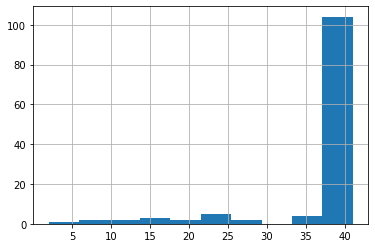

In [25]:
df["variable"].value_counts().sort_values().hist()

##### Check variables with high/low errors
* +- those with few cases?
* I make a pseudo % error target.

In [26]:
df["error_pct"] = 100*(df["y_raw"].sub(df["preds"])).div(df["y_raw"]).round(3).replace([np.inf, -np.inf], np.nan)
display(df["error_pct"].describe().round(1)) # .dropna(axis=0)

count    4692.0
mean      -11.0
std        80.2
min     -2436.0
25%        -1.4
50%         0.0
75%         0.2
max      1391.3
Name: error_pct, dtype: float64

### We see the highest errors in the cases with very short time-frames

In [27]:
df.groupby(["variable"])["error_pct"].median().sort_values()

variable
crispr cas-9        -299.95
biosimilar           -49.70
connectome           -13.40
carbon dating        -10.80
cumin                 -8.75
                      ...  
lncRNA                 0.50
hydrophonics           0.60
machine learning       1.00
neutrotransmitter      9.90
CRISPR                13.10
Name: error_pct, Length: 125, dtype: float64

In [28]:
df_feat

,y_raw,lag5,lag6,year_num,approximatePercentile(sumOfValues(total_value of variable between 11 years and 5 years before Year where value < 582.2528187858203)),sumOfValues(reviews of variable between 11 years and 5 years before Year where total_value < 1.3653440680027905E8),maxValue(research_review_diff of variable between 11 years and 5 years before Year where reviews >= 15.972546580543987),maxValue(value of variable between 11 years and 5 years before Year where total_value < 1.764601813583369E7),maxSlope(research_review_diff of variable between 20 years and 5 years before Year),stddev(total_value of variable between 20 years and 5 years before Year),...,"|sumOfValues(filterByLessThan(slice(last_15_years_from_Year_by_variable_with_5_years_offset, Time Series for trends_context_v5.csv.gz_total_value_history_by_variable, Time Series for trends_context_v5.csv.gz_research_review_ratio_history_by_variable), 0.95)) - 83,901,219|",approximatePercentile(sumOfValues(value of variable between 11 years and 5 years before Year where total_value < 2.5451864359651673E8)),"|recentVSHistoricalAverageRatio(last_6_years_from_Year_by_variable_with_5_years_offset, Time Series for trends_context_v5.csv.gz_reviews_history_by_variable) - 2.45|",|minSlope(smoothMovingAverage10((last_15_years_from_Year_by_variable_with_5_years_offset of Time Series for trends_context_v5.csv.gz_reviews_history_by_variable))) - -2.611100558261196E-4|,sumOfValues(patent_count of variable between 11 years and 5 years before Year where value < 582.2528187858203),minValue(pct_diff of variable between 20 years and 5 years before Year where value >= 56.405431497713856),|minSlope(smoothMovingAverage10((last_15_years_from_Year_by_variable_with_5_years_offset of Time Series for trends_context_v5.csv.gz_total_value_history_by_variable))) - 177.43|,recentVSHistoricalMedianRatio(pct_diff of variable between all past years and 5 years before Year) inRange (-5.78 to 0.99),y_raw_predicted,variable
0,103.509,40.407,34.180,1979,0.450015,5.008870,546.814903,40.406618,0.082183,2.432740e+06,...,8.390122e+07,0.498944,1.012284,0.000209,0.0,-0.097698,134.189105,0.067478,56.201283,BLAST
1,4.963,1.276,2.596,1979,0.212242,0.000000,546.814903,2.595987,0.006659,1.511492e+05,...,8.390122e+07,0.212936,1.015355,0.000261,0.0,-0.097698,203.786004,0.116381,4.354179,Insular cortex
2,2.836,7.231,7.788,1979,0.344580,7.506406,546.814903,14.920854,0.019958,9.257182e+05,...,8.390122e+07,0.361609,1.308846,0.000384,0.0,-0.097698,250.957796,0.400000,8.177945,prion
3,456.572,671.175,643.372,1979,0.737255,127.352793,361.958232,15.277181,0.123136,2.959412e+07,...,1.161626e+09,0.931656,0.747841,0.004297,0.0,-0.354569,10401.323282,0.502297,570.992371,pituitary gland
4,38.284,91.447,92.158,1979,0.588619,61.828057,546.814903,15.277181,0.070897,6.485428e+06,...,1.408531e+08,0.635198,0.827481,0.000319,0.0,-0.310101,1229.045522,0.108356,89.756790,LSD
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4693,113.147,88.936,79.758,2019,0.728451,19.873860,546.814903,15.277181,0.056798,2.491897e+07,...,4.244381e+08,0.588269,4.807943,0.000809,103.0,0.018504,11478.954314,0.557365,147.508102,nanopore
4694,147.432,169.990,181.781,2019,0.915600,0.000000,-409.760666,15.277181,0.070560,2.196873e+07,...,2.683073e+09,0.758944,1.430209,0.005351,93.0,-0.127640,16866.108833,0.747303,197.493896,Norepinephrine
4695,2733.066,1309.316,986.664,2019,0.100000,0.000000,1300.190316,15.277181,0.874466,1.961654e+08,...,8.390122e+07,0.100000,0.633738,0.005929,0.0,-0.042360,62552.404672,0.623270,1559.638550,natural medicine
4696,2880.427,3060.408,3104.808,2019,0.100000,0.000000,2735.069794,15.277181,0.373260,5.488357e+08,...,2.879182e+10,0.100000,0.486706,0.017933,0.0,-0.014300,295992.970255,0.367391,3182.323730,fMRI


### REMOVE variables with too few cases
* this will improve modelling results! 

In [29]:
if FILTER_GROUP_SIZES:
    print(df_feat.shape[0])
    element_group_sizes = df_feat['variable'].groupby(df_feat['variable']).transform('count')
    df_feat = df_feat[element_group_sizes>5]
    df_feat.reset_index(inplace=True,drop=True) # otherwise, error ?? 
    print(df_feat.shape[0])

4698
4696


In [30]:
display(df_feat["y_raw"].describe().round(2))

count     4696.00
mean       636.64
std       1329.10
min          0.00
25%         30.95
50%        173.50
75%        565.62
max      11909.16
Name: y_raw, dtype: float64

#### opt: make different, touger differenced target

In [31]:
if DIFF_TARGET:
    df_feat["y_raw"] = df_feat["y_raw"].sub(df_feat["lag5"])
#     df_feat["y_raw"] = df_feat["y_raw"].div(df_feat["lag5"]) # alt, pct change target
    df_feat.dropna(subset=["y_raw"],inplace=True)
    df_feat.reset_index(inplace=True,drop=True)
    display(df_feat["y_raw"].describe().round(2))

### temporal CV

* https://stackoverflow.com/questions/41753795/sklearn-timeseriessplit-cross-val-predict-only-works-for-partitions

In [32]:
num_cols = list(df_feat.select_dtypes("number").drop(columns=["y_raw","y_raw_predicted","preds"],errors="ignore").columns)

# X = df_feat.filter(["variable"]+num_cols,axis=1).copy()

X = df_feat[["variable"]+num_cols]#.copy() # try values ? 
# X = X.fillna(0)
y = df_feat["y_raw"]#.copy()#.values

# ## https://stackoverflow.com/questions/41753795/sklearn-timeseriessplit-cross-val-predict-only-works-for-partitions
# preds = cross_val_predict(clf,X.fillna(0),y,cv=cv.split(df_feat))

In [33]:
print(len(X))
X

4696


,variable,lag5,lag6,year_num,approximatePercentile(sumOfValues(total_value of variable between 11 years and 5 years before Year where value < 582.2528187858203)),sumOfValues(reviews of variable between 11 years and 5 years before Year where total_value < 1.3653440680027905E8),maxValue(research_review_diff of variable between 11 years and 5 years before Year where reviews >= 15.972546580543987),maxValue(value of variable between 11 years and 5 years before Year where total_value < 1.764601813583369E7),maxSlope(research_review_diff of variable between 20 years and 5 years before Year),stddev(total_value of variable between 20 years and 5 years before Year),...,maxSlope(detrend(research_review_diff of variable between 20 years and 5 years before Year)),recentVSHistoricalMedianDifference(reviews of variable between all past years and 5 years before Year),"|sumOfValues(filterByLessThan(slice(last_15_years_from_Year_by_variable_with_5_years_offset, Time Series for trends_context_v5.csv.gz_total_value_history_by_variable, Time Series for trends_context_v5.csv.gz_research_review_ratio_history_by_variable), 0.95)) - 83,901,219|",approximatePercentile(sumOfValues(value of variable between 11 years and 5 years before Year where total_value < 2.5451864359651673E8)),"|recentVSHistoricalAverageRatio(last_6_years_from_Year_by_variable_with_5_years_offset, Time Series for trends_context_v5.csv.gz_reviews_history_by_variable) - 2.45|",|minSlope(smoothMovingAverage10((last_15_years_from_Year_by_variable_with_5_years_offset of Time Series for trends_context_v5.csv.gz_reviews_history_by_variable))) - -2.611100558261196E-4|,sumOfValues(patent_count of variable between 11 years and 5 years before Year where value < 582.2528187858203),minValue(pct_diff of variable between 20 years and 5 years before Year where value >= 56.405431497713856),|minSlope(smoothMovingAverage10((last_15_years_from_Year_by_variable_with_5_years_offset of Time Series for trends_context_v5.csv.gz_total_value_history_by_variable))) - 177.43|,recentVSHistoricalMedianRatio(pct_diff of variable between all past years and 5 years before Year) inRange (-5.78 to 0.99)
0,BLAST,40.407,34.180,1979,0.450015,5.008870,546.814903,40.406618,0.082183,2.432740e+06,...,0.078311,0.432664,8.390122e+07,0.498944,1.012284,0.000209,0.0,-0.097698,134.189105,0.067478
1,Insular cortex,1.276,2.596,1979,0.212242,0.000000,546.814903,2.595987,0.006659,1.511492e+05,...,0.006691,0.000000,8.390122e+07,0.212936,1.015355,0.000261,0.0,-0.097698,203.786004,0.116381
2,prion,7.231,7.788,1979,0.344580,7.506406,546.814903,14.920854,0.019958,9.257182e+05,...,0.017879,1.297993,8.390122e+07,0.361609,1.308846,0.000384,0.0,-0.097698,250.957796,0.400000
3,pituitary gland,671.175,643.372,1979,0.737255,127.352793,361.958232,15.277181,0.123136,2.959412e+07,...,0.180504,36.216008,1.161626e+09,0.931656,0.747841,0.004297,0.0,-0.354569,10401.323282,0.502297
4,LSD,91.447,92.158,1979,0.588619,61.828057,546.814903,15.277181,0.070897,6.485428e+06,...,0.070725,8.658956,1.408531e+08,0.635198,0.827481,0.000319,0.0,-0.310101,1229.045522,0.108356
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4691,nanopore,88.936,79.758,2019,0.728451,19.873860,546.814903,15.277181,0.056798,2.491897e+07,...,0.041909,2.734893,4.244381e+08,0.588269,4.807943,0.000809,103.0,0.018504,11478.954314,0.557365
4692,Norepinephrine,169.990,181.781,2019,0.915600,0.000000,-409.760666,15.277181,0.070560,2.196873e+07,...,0.139913,-7.101160,2.683073e+09,0.758944,1.430209,0.005351,93.0,-0.127640,16866.108833,0.747303
4693,natural medicine,1309.316,986.664,2019,0.100000,0.000000,1300.190316,15.277181,0.874466,1.961654e+08,...,0.822823,172.597212,8.390122e+07,0.100000,0.633738,0.005929,0.0,-0.042360,62552.404672,0.623270
4694,fMRI,3060.408,3104.808,2019,0.100000,0.000000,2735.069794,15.277181,0.373260,5.488357e+08,...,0.186253,330.959182,2.879182e+10,0.100000,0.486706,0.017933,0.0,-0.014300,295992.970255,0.367391


In [34]:
# cv = TimeSeriesSplit(n_splits=5)
# clf = Ridge(alpha=0.5) # HistGradientBoostingRegressor
# clf =HistGradientBoostingRegressor(categorical_features=categorical_mask)
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.compose import make_column_selector
from sklearn.preprocessing import OrdinalEncoder
import numpy as np

# ## https://scikit-learn.org/stable/auto_examples/ensemble/plot_gradient_boosting_categorical.html#sphx-glr-auto-examples-ensemble-plot-gradient-boosting-categorical-py
# # X["variable"] = X["variable"].astype("category")

# n_categorical_features = X.select_dtypes(include="category").shape[1] # 1 
# categorical_mask = [True] * 1 + [False] * (X.shape[1]-1) # 133 , categorical is first feat

# ordinal_encoder = make_column_transformer(
#     (
#         OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=np.nan),
#         make_column_selector(dtype_include="category"),
#     ),
#     remainder="passthrough",
# )

# clf = make_pipeline(
#     ordinal_encoder,
#     HistGradientBoostingRegressor(
#         random_state=42, categorical_features=categorical_mask
#     ),
# )
# #### memory errors? 

In [35]:
df_feat

,y_raw,lag5,lag6,year_num,approximatePercentile(sumOfValues(total_value of variable between 11 years and 5 years before Year where value < 582.2528187858203)),sumOfValues(reviews of variable between 11 years and 5 years before Year where total_value < 1.3653440680027905E8),maxValue(research_review_diff of variable between 11 years and 5 years before Year where reviews >= 15.972546580543987),maxValue(value of variable between 11 years and 5 years before Year where total_value < 1.764601813583369E7),maxSlope(research_review_diff of variable between 20 years and 5 years before Year),stddev(total_value of variable between 20 years and 5 years before Year),...,"|sumOfValues(filterByLessThan(slice(last_15_years_from_Year_by_variable_with_5_years_offset, Time Series for trends_context_v5.csv.gz_total_value_history_by_variable, Time Series for trends_context_v5.csv.gz_research_review_ratio_history_by_variable), 0.95)) - 83,901,219|",approximatePercentile(sumOfValues(value of variable between 11 years and 5 years before Year where total_value < 2.5451864359651673E8)),"|recentVSHistoricalAverageRatio(last_6_years_from_Year_by_variable_with_5_years_offset, Time Series for trends_context_v5.csv.gz_reviews_history_by_variable) - 2.45|",|minSlope(smoothMovingAverage10((last_15_years_from_Year_by_variable_with_5_years_offset of Time Series for trends_context_v5.csv.gz_reviews_history_by_variable))) - -2.611100558261196E-4|,sumOfValues(patent_count of variable between 11 years and 5 years before Year where value < 582.2528187858203),minValue(pct_diff of variable between 20 years and 5 years before Year where value >= 56.405431497713856),|minSlope(smoothMovingAverage10((last_15_years_from_Year_by_variable_with_5_years_offset of Time Series for trends_context_v5.csv.gz_total_value_history_by_variable))) - 177.43|,recentVSHistoricalMedianRatio(pct_diff of variable between all past years and 5 years before Year) inRange (-5.78 to 0.99),y_raw_predicted,variable
0,103.509,40.407,34.180,1979,0.450015,5.008870,546.814903,40.406618,0.082183,2.432740e+06,...,8.390122e+07,0.498944,1.012284,0.000209,0.0,-0.097698,134.189105,0.067478,56.201283,BLAST
1,4.963,1.276,2.596,1979,0.212242,0.000000,546.814903,2.595987,0.006659,1.511492e+05,...,8.390122e+07,0.212936,1.015355,0.000261,0.0,-0.097698,203.786004,0.116381,4.354179,Insular cortex
2,2.836,7.231,7.788,1979,0.344580,7.506406,546.814903,14.920854,0.019958,9.257182e+05,...,8.390122e+07,0.361609,1.308846,0.000384,0.0,-0.097698,250.957796,0.400000,8.177945,prion
3,456.572,671.175,643.372,1979,0.737255,127.352793,361.958232,15.277181,0.123136,2.959412e+07,...,1.161626e+09,0.931656,0.747841,0.004297,0.0,-0.354569,10401.323282,0.502297,570.992371,pituitary gland
4,38.284,91.447,92.158,1979,0.588619,61.828057,546.814903,15.277181,0.070897,6.485428e+06,...,1.408531e+08,0.635198,0.827481,0.000319,0.0,-0.310101,1229.045522,0.108356,89.756790,LSD
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4691,113.147,88.936,79.758,2019,0.728451,19.873860,546.814903,15.277181,0.056798,2.491897e+07,...,4.244381e+08,0.588269,4.807943,0.000809,103.0,0.018504,11478.954314,0.557365,147.508102,nanopore
4692,147.432,169.990,181.781,2019,0.915600,0.000000,-409.760666,15.277181,0.070560,2.196873e+07,...,2.683073e+09,0.758944,1.430209,0.005351,93.0,-0.127640,16866.108833,0.747303,197.493896,Norepinephrine
4693,2733.066,1309.316,986.664,2019,0.100000,0.000000,1300.190316,15.277181,0.874466,1.961654e+08,...,8.390122e+07,0.100000,0.633738,0.005929,0.0,-0.042360,62552.404672,0.623270,1559.638550,natural medicine
4694,2880.427,3060.408,3104.808,2019,0.100000,0.000000,2735.069794,15.277181,0.373260,5.488357e+08,...,2.879182e+10,0.100000,0.486706,0.017933,0.0,-0.014300,295992.970255,0.367391,3182.323730,fMRI


In [36]:
%%time 
# tscv = TimeSeriesSplit(10)
df_feat["preds"] = np.NaN

# def evaluate(model = None,X):
#     """https://stats.stackexchange.com/questions/495151/cross-validation-for-time-series-what-am-i-doing-wrong
#     https://stackoverflow.com/questions/51597507/sklearn-timeseriessplit-error-keyerror-0-1-2-not-in-index
#     """
#     # train model on training dataset
#     i = 0
#     tscv = TimeSeriesSplit(7)
#     # df_feat["preds"] = np.NaN
#     for train_index, test_index in tscv.split(X): #df_feat):
#         i +=1
#         print(i)
# #         if i%2==0: print(i)
#         X_train, X_test = X.iloc[train_index], X.iloc[test_index]
# #         X_train, X_test = X.index[train_index], X.index[test_index]#X.iloc[train_index], X.iloc[test_index]
#         y_train, y_test = y[train_index], y[test_index]
#         model = CatBoostRegressor(iterations=1000,
#                                   cat_features= ["variable"],#[0], #["variable"],
#                           verbose=False,has_time=True)
# #         print("fit")
# #         model.fit(X_train, y_train)
#         model.fit(X_train, y_train,early_stopping_rounds=10,
#                   eval_set=(X_test, y_test),#plot=(i%3==0),
# #                  baseline=X_train["lag5"].values)#pd.concat([X_train["lag5"],X_test["lag5"]]).values)
#                   )
# #         print("doing pred")
#         y_predict = model.predict(X_test)
# #         print("assigning pred")
# #         df_feat.loc[test_index,"preds"] =y_predict
#         df_feat.iloc[test_index,-1] =y_predict  ##
#     print("\n Done")

# evaluate(model=clf)
evaluate(X=X)

display(df_feat.filter(["year_num","y_raw","preds","y_raw_predicted","variable"],axis=1).dropna(axis=0))
print(df_feat.filter(["year_num","y_raw","preds","y_raw_predicted"],axis=1).corrwith(df_feat["y_raw"]).round(3).sort_values())

1


<timed exec>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


2
3
4
5
6
7
8
9
10

 Done


,year_num,y_raw,preds,y_raw_predicted,variable
436,1983,2.261,9.275638,1.737640,carbon dating
437,1983,0.969,-1.027850,0.853666,machine learning
438,1983,196.749,230.790622,196.700760,multiple sclerosis
439,1983,79.152,83.803428,78.851723,natural medicine
440,1983,493.972,481.798840,493.646912,pituitary gland
...,...,...,...,...,...
4691,2019,113.147,170.359890,147.508102,nanopore
4692,2019,147.432,110.863129,197.493896,Norepinephrine
4693,2019,2733.066,1586.788573,1559.638550,natural medicine
4694,2019,2880.427,3155.247011,3182.323730,fMRI


year_num           0.085
preds              0.987
y_raw_predicted    0.996
y_raw              1.000
dtype: float64
CPU times: user 12min 56s, sys: 6min 56s, total: 19min 53s
Wall time: 1min 42s


In [37]:
df_feat.set_index("year_num",inplace=True)

In [38]:
y_true = df_feat.dropna(subset=["preds"])["y_raw"]
y_pred = df_feat.dropna(subset=["preds"])["preds"]

regression_results(y_true, y_pred)

r2:  0.971
MAE (Mean absolute error): 93.9272
Median absolute error): 30.3148
RMSE:  231.3058
explained_variance:  0.971
mape:  74389660811650.17


### Plot Predictions


In [39]:
df_feat["y_raw"].notna().sum()

4696

In [40]:
df_feat["preds"].notna().sum()

4260

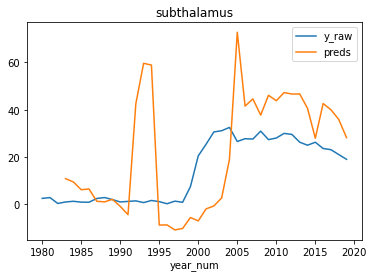

In [41]:
plot_var_preds(df_feat,"subthalamus")

In [42]:
# df_feat.loc[df_feat["variable"].str.contains("subthalamus",case=False)]#[["y_raw","y_raw_predicted"]]

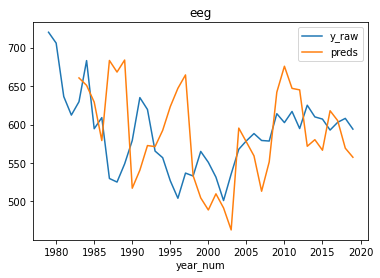

In [43]:
plot_var_preds(df_feat,"eeg")

In [44]:
# df.loc[df["variable"].str.contains("neural networks",case=False)][["y_raw","y_raw_predicted"]].plot(title="neural networks")

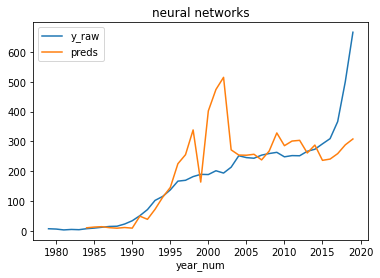

In [45]:
plot_var_preds(df_feat,"neural networks")

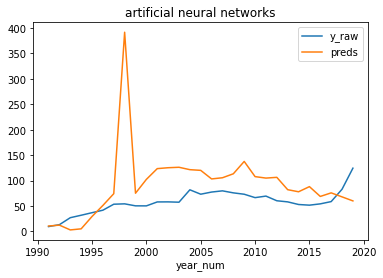

In [46]:
plot_var_preds(df_feat,"artificial neural networks")

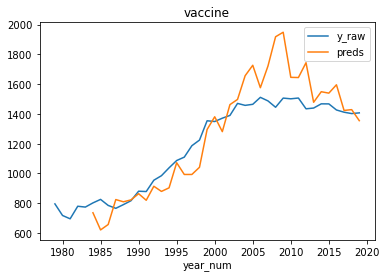

In [47]:
plot_var_preds(df_feat,"vaccine")

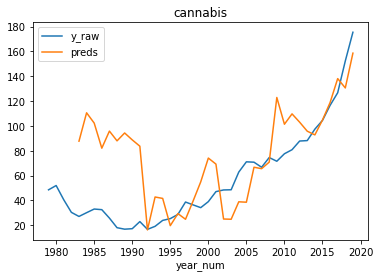

In [48]:
plot_var_preds(df_feat,"cannabis")

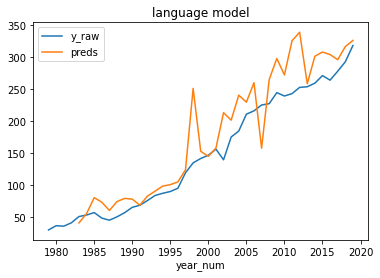

In [49]:
plot_var_preds(df_feat,"language model")

In [50]:
df.loc[df["start"].dt.year>1990]["variable"].unique()

array(['artificial neural networks', 'graph neural network', 'buckyballs',
       'carbon nanotubes', 'BRCA1', 'GWAS', 'BRCA2', 'illumina',
       'nanopore', 'metabolome', 'metagenomics', 'miRNA', 'CRISPR',
       'biosimilar', 'connectome', 'crispr cas-9'], dtype=object)

In [51]:
# df_feat.loc[df_feat["variable"]=="BRCA1"] ## why no preds?

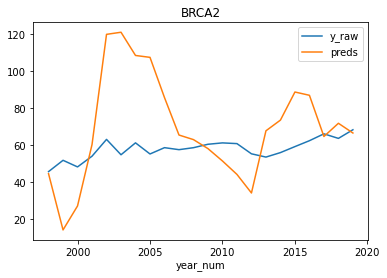

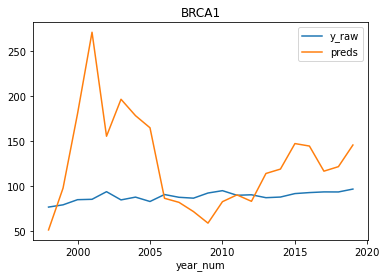

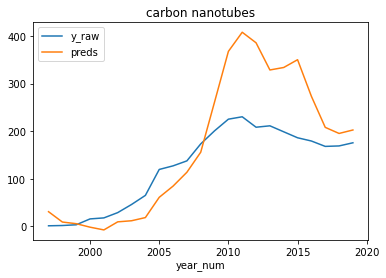

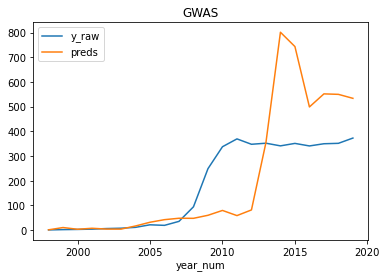

In [52]:
for i in ['BRCA2', 'BRCA1', 'carbon nanotubes', 'GWAS']:
    plot_var_preds(df_feat,i)

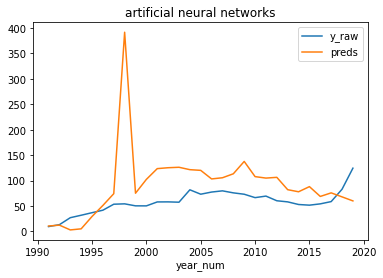

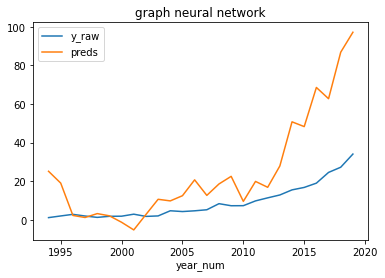

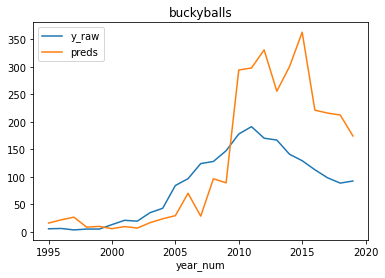

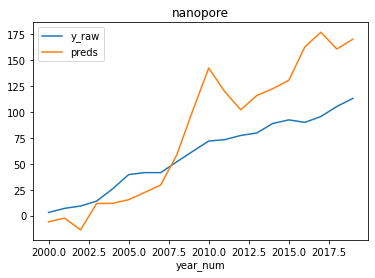

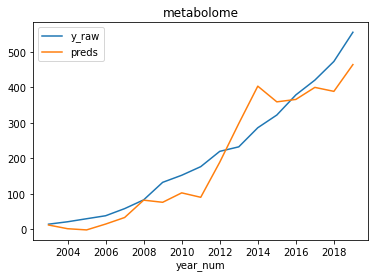

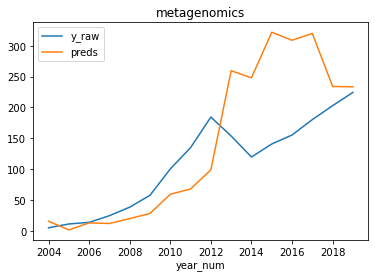

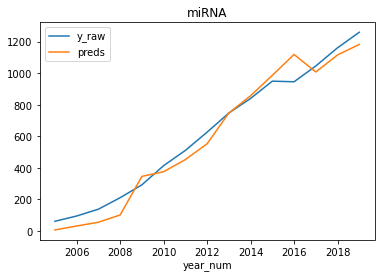

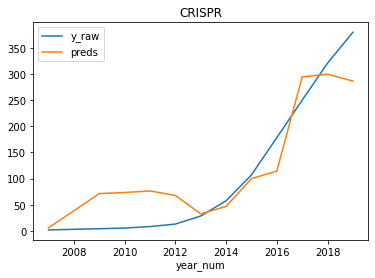

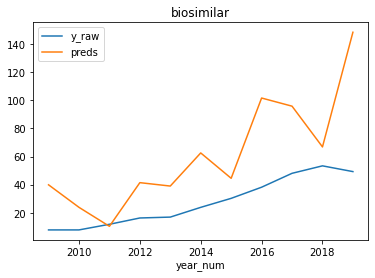

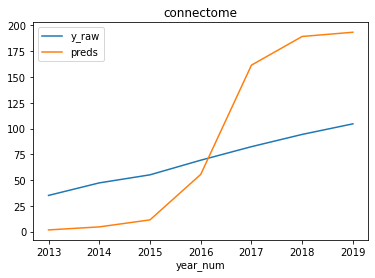

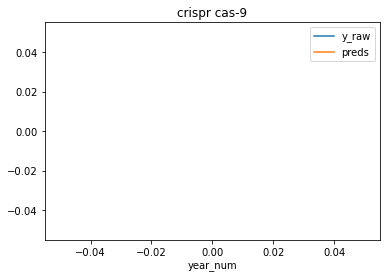

In [53]:
for i in ['artificial neural networks', 'graph neural network', 'buckyballs',
#        'carbon nanotubes', 'BRCA2', 'BRCA1', 'GWAS',
       'nanopore', 'metabolome', 'metagenomics', 'miRNA', 'CRISPR',
       'biosimilar', 'connectome', 'crispr cas-9',]:
    plot_var_preds(df_feat,i)

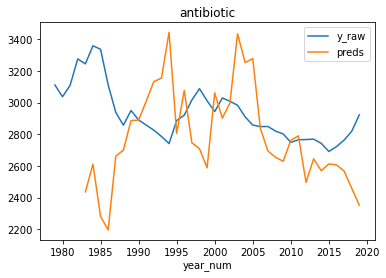

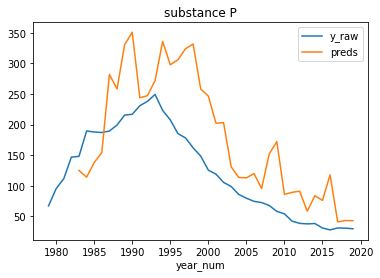

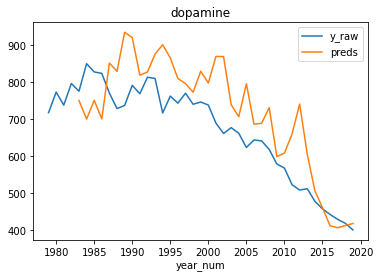

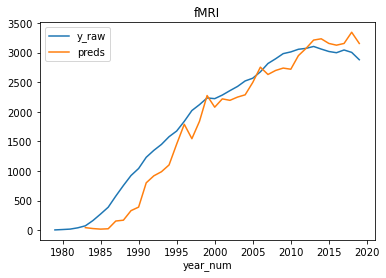

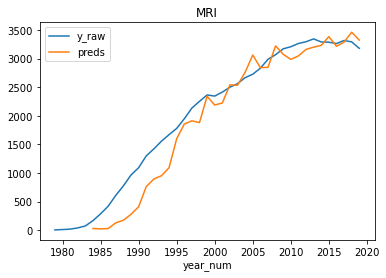

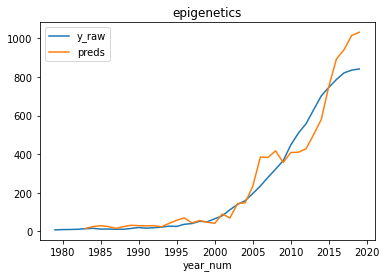

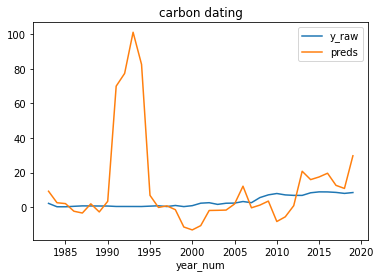

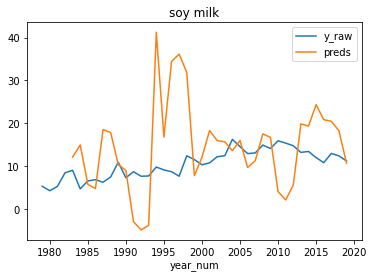

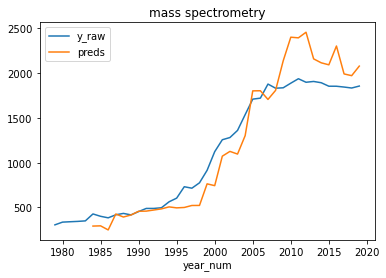

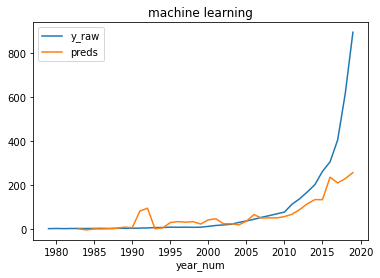

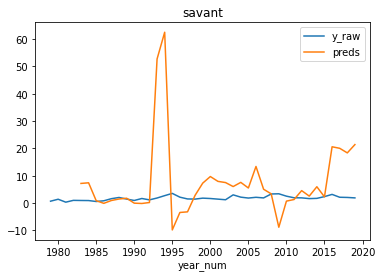

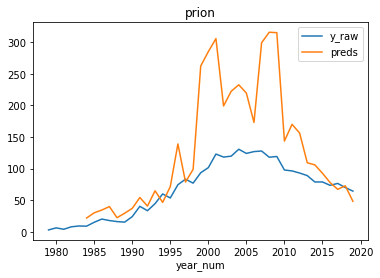

In [54]:
for i in ['antibiotic','substance P', 'dopamine', 'fMRI', 'MRI', 'epigenetics',
       'carbon dating', 'soy milk', 'mass spectrometry', 
       'machine learning', 'savant', 'prion']:
    plot_var_preds(df_feat,i)

In [55]:
df_feat.loc[df_feat["variable"].str.contains("neural networks",case=False)][["variable","y_raw","preds"]]

,variable,y_raw,preds
year_num,,,
1979,neural networks,6.735,NaN
1980,neural networks,5.701,NaN
1981,neural networks,2.820,NaN
1982,neural networks,4.395,NaN
1983,neural networks,3.554,NaN
...,...,...,...
2017,neural networks,366.520,258.931240
2018,artificial neural networks,82.857,67.866814
2018,neural networks,500.485,288.393177
